In [1]:
# === SEKCJA 1: IMPORT I KONFIGURACJA ===
import pandas as pd; import numpy as np; import re;
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.display import display
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors # Ważny import

print("Wczytywanie danych...")
df_main = pd.read_csv('data.csv', sep=',')
df_ulic = pd.read_csv('Ulic.csv', sep=',')
print("Wszystkie pliki wczytane.")

Wczytywanie danych...


C:\Users\Ai\AppData\Local\Temp\ipykernel_1056\1474917639.py:17: DtypeWarning: Columns (15,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv('data.csv', sep=',')


Wszystkie pliki wczytane.


In [2]:
# === SEKCJA 2: WCZYTANIE I PRZYGOTOWANIE DANYCH ===

print("Wczytywanie danych...")
df_main = pd.read_csv('data.csv', sep=',')
df_ulic = pd.read_csv('Ulic.csv', sep=',')
print("Pliki wczytane.")

# --- Krok 2a: Stworzenie słownika ulic ---
df_ulic.rename(columns={'Name': 'NAZWA_ULICY'}, inplace=True)
df_ulic.dropna(subset=['SymUl', 'NAZWA_ULICY'], inplace=True)
street_dictionary = pd.Series(df_ulic.NAZWA_ULICY.values, index=df_ulic.SymUl).to_dict()
print(f"Utworzono słownik z {len(street_dictionary)} unikalnymi ulicami.")

# --- Krok 2b: Wzbogacanie i czyszczenie ---
df_processed = df_main.copy()
df_processed.dropna(subset=['Area', 'Price', 'Description', 'Location', 'StreetNumber'], inplace=True)

def process_location(row):
    location_str = row['Location']
    district, street = np.nan, np.nan
    if isinstance(location_str, str):
        parts = [p.strip() for p in location_str.split(',')]
        if len(parts) >= 3 and 'warszawa' in parts[1].lower():
            district = parts[2]
    if pd.notna(row['StreetNumber']):
        try:
            street_sym = int(row['StreetNumber'])
            if street_sym in street_dictionary:
                street = street_dictionary[street_sym]
        except (ValueError, TypeError): pass
    if pd.isna(street) and isinstance(location_str, str) and len(location_str.split(',')) >= 4:
        street = location_str.split(',')[3].strip()
    if isinstance(street, str):
        street = re.sub(r'^(ul\.|al\.|pl\.)\s*', '', street, flags=re.IGNORECASE).lower()
        if len(street) < 3: street = np.nan
    return pd.Series([district, street])

df_processed[['District', 'Ulica_clean']] = df_processed.apply(process_location, axis=1)
df_processed.dropna(subset=['Ulica_clean', 'District'], inplace=True)

# --- Krok 2c: Filtrowanie rzadkich ulic ---
MIN_SAMPLES_PER_STREET = 25
street_counts = df_processed['Ulica_clean'].value_counts()
streets_to_remove = street_counts[street_counts < MIN_SAMPLES_PER_STREET].index
df_model_ready = df_processed[~df_processed['Ulica_clean'].isin(streets_to_remove)].copy()
print(f"Finalny zbiór danych gotowy. Liczba wierszy: {len(df_model_ready)}, Liczba unikalnych ulic: {df_model_ready['Ulica_clean'].nunique()}")

Wczytywanie danych...


C:\Users\Ai\AppData\Local\Temp\ipykernel_1056\677810587.py:4: DtypeWarning: Columns (15,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv('data.csv', sep=',')


Pliki wczytane.
Utworzono słownik z 47823 unikalnymi ulicami.
Finalny zbiór danych gotowy. Liczba wierszy: 52543, Liczba unikalnych ulic: 682


In [3]:
# === SEKCJA 3: INŻYNIERIA CECH I WSTĘPNIE TRENOWANE EMBEDDINGI ===

# --- 3a. Przygotowanie danych tekstowych ---
def clean_text(text):
    return re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
df_model_ready['description_clean'] = df_model_ready['Description'].apply(clean_text)

MAX_WORDS = 20000 # Zwiększamy słownik, aby lepiej wykorzystać model nkjp
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_model_ready['description_clean'])
sequences = tokenizer.texts_to_sequences(df_model_ready['description_clean'])
MAX_LEN = 200 # Dłuższe sekwencje
X_text = pad_sequences(sequences, maxlen=MAX_LEN)

# --- 3b. Wczytanie modelu NKJP i tworzenie macierzy embeddingów ---
model_path = 'nkjp+wiki-forms-all-100-cbow-hs.txt'
print(f"\nWczytywanie modelu Word2Vec z pliku: {model_path}...")
wv = KeyedVectors.load_word2vec_format(model_path, binary=False)
print("Model wczytany pomyślnie.")

embedding_dim = 100 # Ten model ma wektory o wymiarze 100
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))
words_found = 0
for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        if word in wv:
            embedding_matrix[i] = wv[word]
            words_found += 1
print(f"\nPrzygotowano macierz embeddingów. Znaleziono {words_found} na {min(MAX_WORDS, len(tokenizer.word_index))} słów.")

# --- 3c. Przygotowanie danych numerycznych i kategorycznych (bez zmian) ---
numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_numeric = numeric_pipeline.fit_transform(df_model_ready[numeric_features])

categorical_features = ['District', 'BuildingType']
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
X_categorical = cat_pipeline.fit_transform(df_model_ready[categorical_features])

# --- 3d. Przygotowanie celu (target) ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_model_ready['Ulica_clean'])
num_classes = len(label_encoder.classes_)
print(f"\nGotowe do treningu. Liczba klas: {num_classes}")


Wczytywanie modelu Word2Vec z pliku: nkjp+wiki-forms-all-100-cbow-hs.txt...
Model wczytany pomyślnie.

Przygotowano macierz embeddingów. Znaleziono 18013 na 20000 słów.

Gotowe do treningu. Liczba klas: 682


In [4]:
# === SEKCJA 4: BUDOWA I TRENING ULEPSZONEJ SIECI NEURONOWEJ ===
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# --- Krok 4a: Definicja Ulepszonej Architektury ---
input_text = Input(shape=(MAX_LEN,), name='text_input')
input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')
input_categorical = Input(shape=(X_categorical.shape[1],), name='categorical_input')

# Warstwa Embedding trenowana od zera, ale z większą pojemnością
embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=256, name='embedding')(input_text)
flatten_layer = Flatten()(embedding_layer)

# Połączenie wszystkich trzech ścieżek
concatenated = Concatenate()([flatten_layer, input_numeric, input_categorical])

# Głębsza i bardziej "pojemna" sieć
x = Dense(1024, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model_v3 = Model(inputs=[input_text, input_numeric, input_categorical], outputs=output_layer)

# --- Krok 4b: Ulepszony Optymalizator i Kompilacja ---
# Używamy Adama z niższym współczynnikiem uczenia dla stabilniejszego treningu
optimizer = Adam(learning_rate=0.0005)
model_v3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_v3.summary()

# --- Krok 4c: Podział na zbiory ---
X_train_text, X_val_text, X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val = train_test_split(
    X_text, X_numeric, X_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Krok 4d: Trening z dodatkowym callbackiem ---
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
# Zmniejszaj współczynnik uczenia, jeśli model utknie w miejscu
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

print("\nRozpoczynam zaawansowany trening ulepszonej sieci...")
history = model_v3.fit(
    [X_train_text, X_train_num, X_train_cat], y_train,
    validation_data=([X_val_text, X_val_num, X_val_cat], y_val),
    epochs=30, # Dajemy więcej czasu
    batch_size=128, # Mniejszy batch size
    callbacks=[early_stopping, reduce_lr]
)

model_v3.save('street_predictor_v3_optimized.keras')
print("\nUlepszony model został zapisany.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 200, 256)          │       5,120,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 51200)             │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ categorical_input             │ (None, 37)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 51242)             │               0 │ flatten[0][0],             │
│                               │                           │                 │ numeric_input[0][0],       │
│                               │                           │                 │ categorical_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1024)              │      52,472,832 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1024)              │           4,096 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1024)              │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 512)               │         524,800 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 512)               │           2,048 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 512)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 256)               │         131,328 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 256)               │           1,024 │ dense_2[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 58,431,402 (222.90 MB)

 Trainable params: 58,427,818 (222.88 MB)

 Non-trainable params: 3,584 (14.00 KB)


Rozpoczynam zaawansowany trening ulepszonej sieci...
Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 56s 164ms/step - accuracy: 0.0298 - loss: 6.6319 - val_accuracy: 0.1153 - val_loss: 5.7274 - learning_rate: 5.0000e-04
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.1364 - loss: 5.3294 - val_accuracy: 0.2290 - val_loss: 4.1681 - learning_rate: 5.0000e-04
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 54s 163ms/step - accuracy: 0.2728 - loss: 3.8302 - val_accuracy: 0.3023 - val_loss: 3.1973 - learning_rate: 5.0000e-04
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.4211 - loss: 2.7016 - val_accuracy: 0.3614 - val_loss: 2.7977 - learning_rate: 5.0000e-04
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.5739 - loss: 1.9268 - val_accuracy: 0.3999 - val_loss: 2.6633 - learning_rate: 5.0000e-04
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.7114 - loss: 1.3339 - val_accuracy: 0.4116 - val_loss: 2.6491 - learning_rate: 5.0

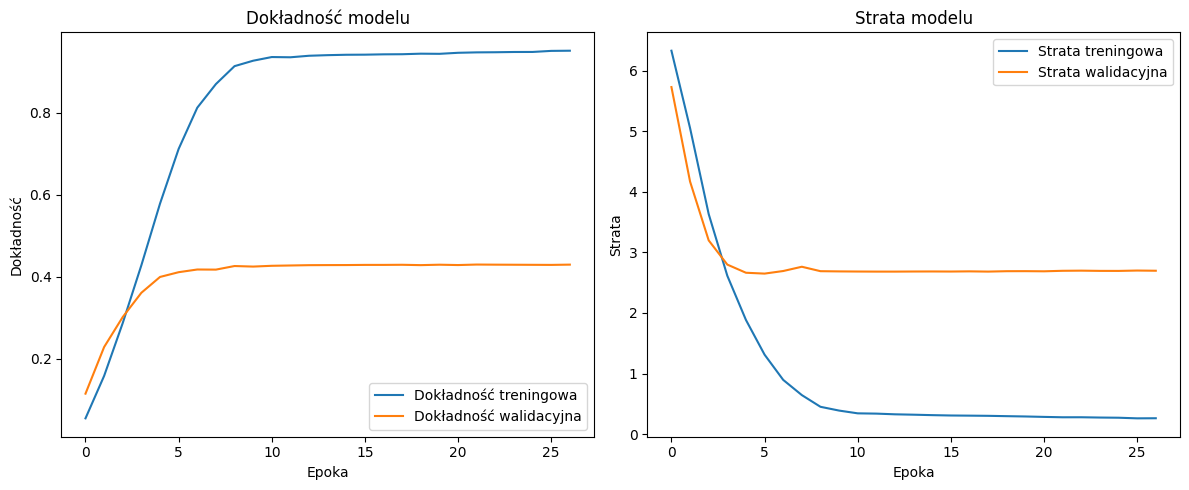

In [5]:
# === SEKCJA 5: WIZUALIZACJA WYNIKÓW TRENINGU ===

# Wykres dokładności
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

# Wykres straty
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.tight_layout()
plt.show()